In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy as sp
import pandas
import time
from matplotlib import cm,ticker
import trap_sim_tools_python_trapSims_HOA.v2.expansion as ep

In [3]:
me = 9.10938356e-31 #kg
fz = 100.0e6 #Hz
omegaz = 2*np.pi*fz
qe = 1.60217662e-19 #coulombs

## Loading electric potential data for each DC electrode plate (20 in total)

In [7]:
# loading left electrodes
pot_data = []
for mod in ["tl"]:
    for i in [1, 2, 3, 4, 5]:
        loc = "DC_pot_top_bottom_match_1.5mm"
        file_name_1 = '/etrap_500u_cube_1.5mm_'+mod+str(i)+'.fld'
        file_name_2 = '/etrap_500u_cube_1.5mm_'+"bl"+str(i)+'.fld'
        full_1 = loc + file_name_1
        full_2 = loc + file_name_2
        data_1 = np.loadtxt(full_1, skiprows=2)
        data_2 = np.loadtxt(full_2, skiprows=2)
        data = data_1 + data_2
        df = pandas.DataFrame(data)
        df.columns = ['V']
        # print (df.head(5))
        # print (df.tail(5))
        V = df.iloc[:,0].values
        
        y = np.arange(-250,251,5)
        z = np.arange(-250,251,5)
        x = np.arange(-250,251,5)
        X = np.tile(x,len(y)*len(z))
        # print (X)
        Z = np.tile(z,(len(y),len(x)))
        Z = np.ndarray.flatten(Z.T)
        # print (Z)
        Y = np.tile(y,(len(z)*len(x),1))
        Y = np.ndarray.flatten(Y.T)
        # print (Y)
        df['Y'] = Y
        df['Z'] = Z
        df['X'] = X
        
        sorted_df = df.sort_values(by=['X', 'Y', 'Z'])
        sorted_df = sorted_df.reset_index(drop=True)
        pot_data.append(sorted_df.iloc[:, 0].values)

# loading right electrodes
for mod in ["tl"]:
    for i in [1, 2, 3, 4, 5]:
        loc = "DC_pot_top_bottom_match_1.5mm"
        file_name_1 = '/etrap_500u_cube_1.5mm_'+mod+str(i)+'.fld'
        file_name_2 = '/etrap_500u_cube_1.5mm_'+"bl"+str(i)+'.fld'
        full_1 = loc + file_name_1
        full_2 = loc + file_name_2
        data_1 = np.loadtxt(full_1, skiprows=2)
        data_2 = np.loadtxt(full_2, skiprows=2)
        data = data_1 + data_2
        df = pandas.DataFrame(data)
        df.columns = ['V']
        # print (df.head(5))
        # print (df.tail(5))
        V = df.iloc[:,0].values
        
        y = np.arange(-250,251,5)
        z = np.arange(-250,251,5)
        x = np.arange(-250,251,5)
        X = np.tile(x,len(y)*len(z))
        # print (X)
        Z = np.tile(z,(len(y),len(x)))
        Z = np.ndarray.flatten(Z.T)
        # print (Z)
        Y = np.tile(y,(len(z)*len(x),1))
        Y = np.ndarray.flatten(Y.T)
        # convert from left to right
        Y = -Y
        # print (Y)
        df['Y'] = Y
        df['Z'] = Z
        df['X'] = X

        sorted_df = df.sort_values(by=['X', 'Y', 'Z'])
        sorted_df = sorted_df.reset_index(drop=True)
        pot_data.append(sorted_df.iloc[:, 0].values)

print("The total number of DC electrodes:", len(pot_data))

The total number of DC electrodes: 10


## Multipole Expansion

In [15]:
order = 2
# Building the M matrix
M_matrix = []
for pot in pot_data:
    result = ep.spher_harm_expansion(pot, [0.0, 0.0, 0.0], np.linspace(-250, 250, 101)*1.0e-6, np.linspace(-250, 250, 101)*1.0e-6,\
                        np.linspace(-250, 250, 101)*1.0e-6, order)
    M_raw = result[0]
    scale = result[2]
    M = []
    for elem in M_raw:
        M.append(elem[0])
    M = np.array(M)
    ft = np.array([False, True, True, True, True, False, False, False, False])
    M_matrix.append(M[ft])
    # M_matrix.append(M)
M_matrix = np.array(M_matrix)
M_matrix = M_matrix.transpose()
print("The shape of the M matrix:", M_matrix.shape)

/Users/timothyguo/Desktop/Haeffner Group/Trap Design Testing/DC_Confinement/trap_sim_tools_python_trapSims_HOA/v2/expansion.py:93: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Mj=np.linalg.lstsq(Yj,W)


The shape of the M matrix: (4, 10)


In [16]:
# Setting the target M vector (choosing the target potential expressed in multipole expansion)
# The correspondence between M vector index and the corresponding multipole is as follows:
# M1 M3 M4 M2 M7 M8 M6 M9 M5 (Using the convention in G. Littich's master thesis (2011))
# 0  1  2  3  4  5  6  7  8  (the ith component of the M_target matrix)
M_target = np.zeros(4)
M_target[3] = 0.5*me*(2*np.pi*fz)**2/qe # M7 is the DC potential I want
# print(M_target)

v = np.linalg.lstsq(M_matrix, M_target)
v = v[0]
print(v)
# print(np.linalg.norm(v))
# kernel = sp.linalg.null_space(M_matrix)
# print(kernel.shape)

# lambda_vector = np.linalg.lstsq(kernel, v)[0]
# print(np.matmul(kernel, lambda_vector))
# v = v - np.matmul(kernel, lambda_vector)
# print(np.linalg.norm(v))

[  4.47698155   6.14131576 -11.71861417   6.8916542   -6.3242882
   4.47698155   6.14131576 -11.71861417   6.8916542   -6.3242882 ]


/Users/timothyguo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if __name__ == '__main__':


In [17]:
fin_pot = np.zeros(len(pot_data[0]))
for i in range(10):
    fin_pot = fin_pot + v[i] * pot_data[i]

In [18]:
ep.spher_harm_expansion(fin_pot, [0.0, 0.0, 0.0], np.linspace(-250, 250, 101)*1.0e-6, np.linspace(-250, 250, 101)*1.0e-6,\
                        np.linspace(-250, 250, 101)*1.0e-6, order)[0]

/Users/timothyguo/Desktop/Haeffner Group/Trap Design Testing/DC_Confinement/trap_sim_tools_python_trapSims_HOA/v2/expansion.py:93: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Mj=np.linalg.lstsq(Yj,W)


array([[-8.64078223e-01],
       [ 5.00659512e-11],
       [ 1.84143084e-11],
       [ 3.87166890e-12],
       [ 1.12229839e+06],
       [ 1.39164382e+03],
       [-9.01535555e-09],
       [-1.15111307e+06],
       [-1.39946561e-09]])

## Plotting the final electric potential using the results given by the multipose expansion

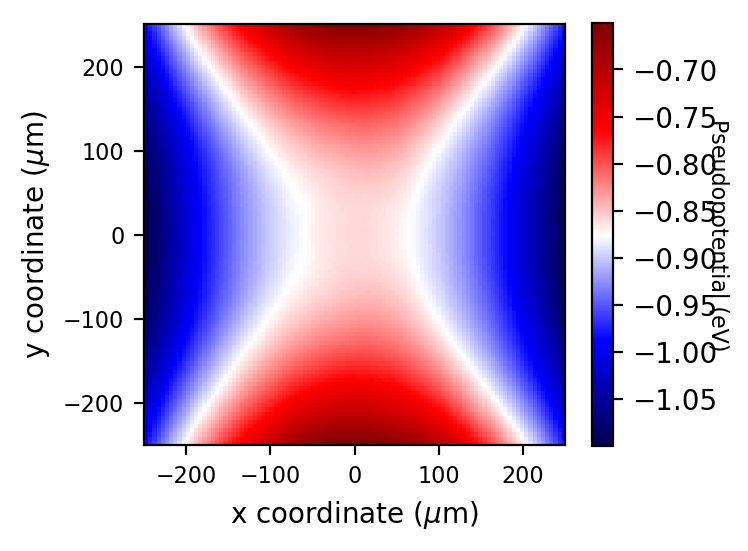

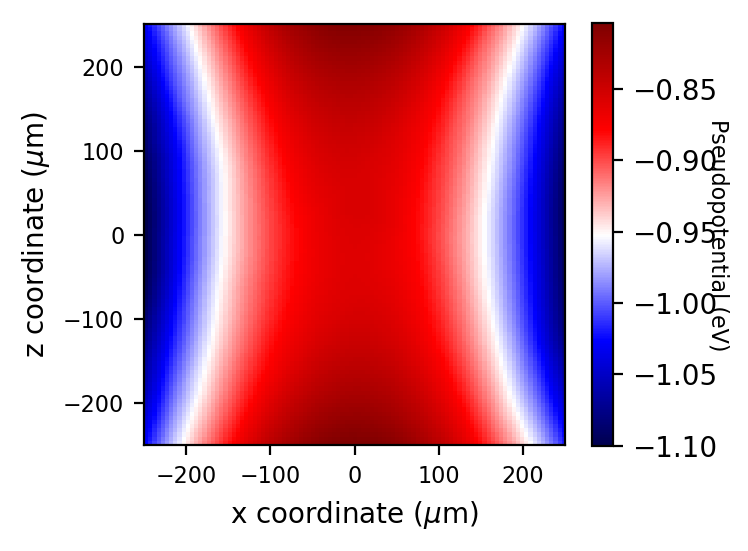

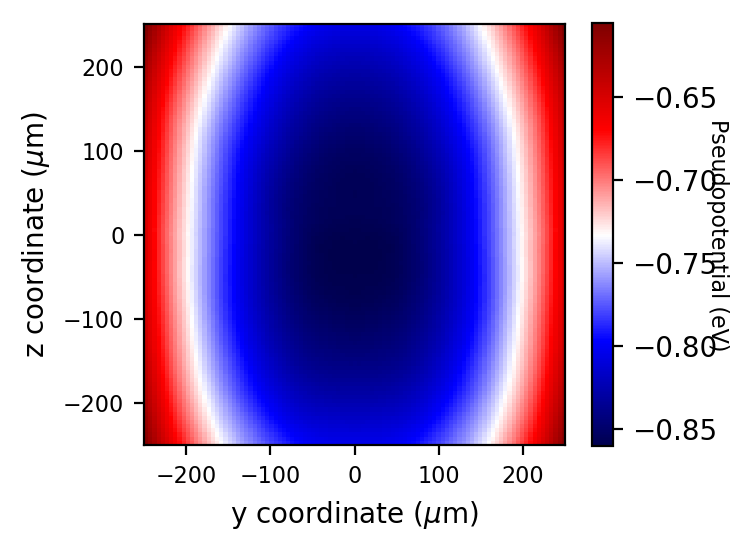

In [19]:
df = pandas.DataFrame(fin_pot)
df.columns = ['V']
# print (df.head(5))
# print (df.tail(5))
V = df.iloc[:,0].values
x = np.arange(-250,251,5)
y = np.arange(-250,251,5)
z = np.arange(-250,251,5)
Z = np.tile(z,len(x)*len(y))
# print (Z)
Y = np.tile(y,(len(x),len(z)))
Y = np.ndarray.flatten(Y.T)
# print (Y)
X = np.tile(x,(len(y)*len(z),1))
X = np.ndarray.flatten(X.T)
# print (X)
df['X'] = X
df['Y'] = Y
df['Z'] = Z

# select cuts in the XY, XZ, YZ planes

# take all df entries where Z = 0
XY_matrix = df[df.Z == 0.0].loc[:, 'V'].values
V_XY = np.reshape(XY_matrix,(101,101))
V_XY = np.flipud(V_XY.transpose())
# take all df entries where Y = 0
XZ_matrix = df[df.Y == 0.0].loc[:, 'V'].values
# print (XZ_matrix[99:110])
V_XZ = np.reshape(XZ_matrix,(101,101))
V_XZ = np.flipud(V_XZ.transpose())
# take all df entries where X = 0
YZ_matrix = df[df.X == 0.0].loc[:, 'V'].values
# print (YZ_matrix[:10])
V_YZ = np.reshape(YZ_matrix,(101,101))
V_YZ = np.flipud(V_YZ.transpose())

# XY plot
plt.figure(figsize = (3.4,2.8), dpi = 200)
# im = plt.imshow(V_XY, interpolation='nearest', extent=[-50.5,50.5,-50.25,50.25], cmap=cm.seismic, vmin=np.log(1.E-3), vmax=np.log(100), origin = 'lower')
im = plt.imshow(V_XY, interpolation='none', extent=[-250.5,250.5,-250.25,250.25], cmap=cm.seismic)
cm.seismic.set_bad(color='yellow')
cbar = plt.colorbar(im)#, ticks=[np.log(0.001), np.log(0.01), np.log(0.1), np.log(1), np.log(10)])
# cbar.ax.set_yticklabels(['0.001', '0.01', '0.1', '1', '10'], fontsize=8)  # vertically oriented colorbar
# cbar.ax.set_title('DC potential due to DC_tl1 (eV)', fontsize = 8)
cbar.set_label('Pseudopotential (eV)', fontsize = 8, rotation=270)
plt.xlabel('x coordinate ($\mu$m)', fontdict=None, labelpad=None)
plt.ylabel('y coordinate ($\mu$m)', fontdict=None, labelpad=None)
plt.tick_params(axis='both', which='major', labelsize=8)
# plt.savefig('Fusion_3D_100MHz_100V_oop_ps.png', bbox_inches = 'tight')
plt.show()

# XZ plot
plt.figure(figsize = (3.4,2.8), dpi = 200)
im = plt.imshow(V_XZ, interpolation='nearest', extent=[-250.5,250.5,-250.25,250.25], cmap=cm.seismic)
cm.seismic.set_bad(color='yellow')
cbar = plt.colorbar(im)#, ticks=[np.log(0.001), np.log(0.01), np.log(0.1), np.log(1), np.log(10)])
# cbar.ax.set_yticklabels(['0.001', '0.01', '0.1', '1', '10'], fontsize=8)  # vertically oriented colorbar
# cbar.ax.set_title('Pseudopotential (eV)', fontsize = 8)
cbar.set_label('Pseudopotential (eV)', fontsize = 8, rotation=270)
plt.xlabel('x coordinate ($\mu$m)', fontdict=None, labelpad=None)
plt.ylabel('z coordinate ($\mu$m)', fontdict=None, labelpad=None)
plt.tick_params(axis='both', which='major', labelsize=8)
# plt.savefig('Fusion_3D_100MHz_100V_oop_ps.png', bbox_inches = 'tight')
plt.show()

# YZ plot
plt.figure(figsize = (3.4,2.8), dpi = 200)
im = plt.imshow(V_YZ, interpolation='nearest', extent=[-250.5,250.5,-250.25,250.25], cmap=cm.seismic)
cm.seismic.set_bad(color='yellow')
cbar = plt.colorbar(im)#, ticks=[np.log(0.001), np.log(0.01), np.log(0.1), np.log(1), np.log(10)])
# cbar.ax.set_yticklabels(['0.001', '0.01', '0.1', '1', '10'], fontsize=8)  # vertically oriented colorbar
# cbar.ax.set_title('Pseudopotential (eV)', fontsize = 8)
cbar.set_label('Pseudopotential (eV)', fontsize = 8, rotation=270)
plt.xlabel('y coordinate ($\mu$m)', fontdict=None, labelpad=None)
plt.ylabel('z coordinate ($\mu$m)', fontdict=None, labelpad=None)
plt.tick_params(axis='both', which='major', labelsize=8)
# plt.savefig('Fusion_3D_100MHz_100V_oop_ps.png', bbox_inches = 'tight')
plt.show()



88.50051499322383 MHz


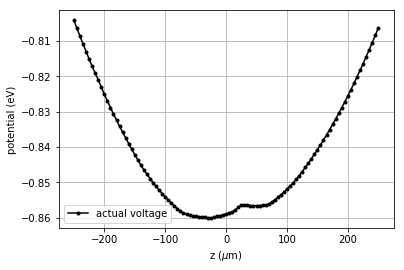

In [20]:
x = np.linspace(-250.0e-6, 250.0e-6, 101)
y = df.loc[(df.X == 0.0) & (df.Y == 0.0)].loc[:, 'V'].values
plt.plot(x*1.0e6, y, color="black", marker=".", label="actual voltage")
plt.xlabel("z ($\mu$m)")
plt.ylabel("potential (eV)")

z_th = np.linspace(-250, 250, 101)
pot_th = 0.5*me*omegaz**2*(z_th*1.0e-6)**2/qe
# plt.plot(z_th, pot_th, 'r-', label="ideal harmonic potential")

a, b, c = np.polyfit(x, y, 2)
# plt.plot(x*1.0e6, a*x**2 + b*x + c, color = "black", label="quadratic fit")

plt.grid(True)
plt.legend()
f_fit = 1/(2*np.pi)*np.sqrt(2*a*qe/me)
print(f_fit*1.0e-6, "MHz")

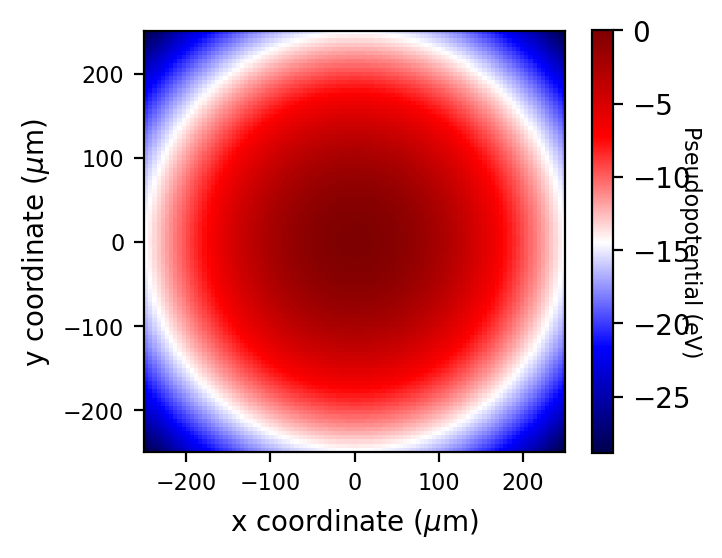

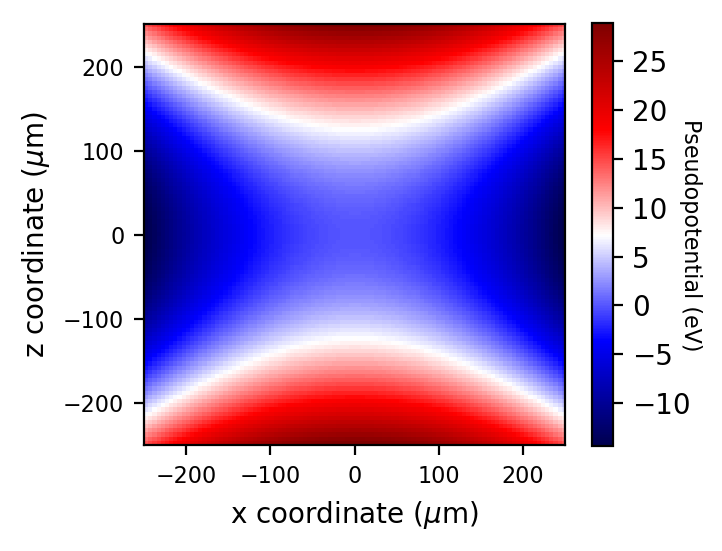

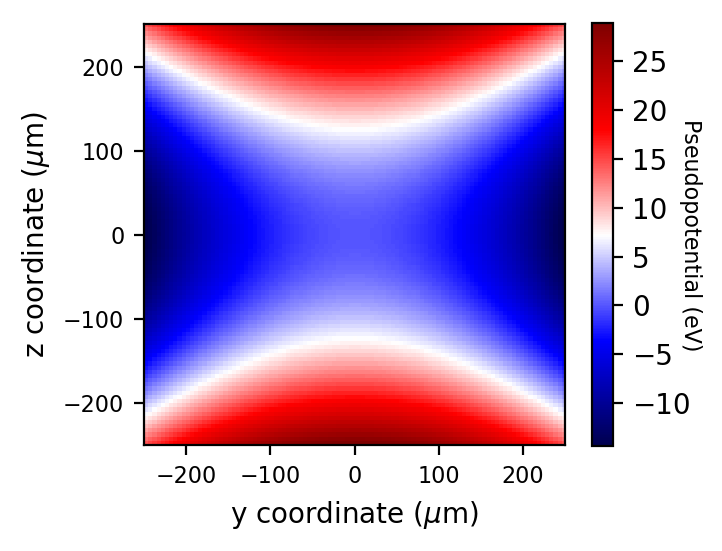

In [32]:
Q = ep.spher_harm_basis([0.0, 0.0, 0.0], np.linspace(-250, 250, 101)*1.0e-6, np.linspace(-250, 250, 101)*1.0e-6,\
                        np.linspace(-250, 250, 101)*1.0e-6, 2)[0]
pole = Q.transpose()
df = pandas.DataFrame(pole[4])
# # if includes grid, use following
# df = df.iloc[:, [0,1,2,4]]
# # print (df.head(5))
# # print (df.tail(5))
# df.columns = ['X', 'Y','Z','V']
# print (df.head(5))
# print (df.tail(5))
# X = df.iloc[:,0].values
# Y = df.iloc[:,1].values
# Z = df.iloc[:,2].values
# V = df.iloc[:,3].values
# print (np.amin(np.abs(X)))

# if doesn't include grid, use this:
df.columns = ['V']
# print (df.head(5))
# print (df.tail(5))
V = df.iloc[:,0].values
x = np.arange(-50,51,1)
y = np.arange(-50,51,1)
z = np.arange(-50,51,1)
Z = np.tile(z,len(x)*len(y))
# print (Z)
Y = np.tile(y,(len(x),len(z)))
Y = np.ndarray.flatten(Y.T)
# print (Y)
X = np.tile(x,(len(y)*len(z),1))
X = np.ndarray.flatten(X.T)
# print (X)
df['X'] = X
df['Y'] = Y
df['Z'] = Z


# select cuts in the XY, XZ, YZ planes

# take all df entries where Z = 0
XY_matrix = df[df.Z == 0.0].loc[:, 'V'].values
V_XY = np.reshape(XY_matrix,(101,101))
V_XY = np.flipud(V_XY.transpose())
# take all df entries where Y = 0
XZ_matrix = df[df.Y == 0.0].loc[:, 'V'].values
# print (XZ_matrix[99:110])
V_XZ = np.reshape(XZ_matrix,(101,101))
V_XZ = np.flipud(V_XZ.transpose())
# take all df entries where X = 0
YZ_matrix = df[df.X == 0.0].loc[:, 'V'].values
# print (YZ_matrix[:10])
V_YZ = np.reshape(YZ_matrix,(101,101))
V_YZ = np.flipud(V_YZ.transpose())

# XY plot
plt.figure(figsize = (3.4,2.8), dpi = 200)
# im = plt.imshow(V_XY, interpolation='nearest', extent=[-50.5,50.5,-50.25,50.25], cmap=cm.seismic, vmin=np.log(1.E-3), vmax=np.log(100), origin = 'lower')
im = plt.imshow(V_XY, interpolation='none', extent=[-250.5,250.5,-250.25,250.25], cmap=cm.seismic)
cm.seismic.set_bad(color='yellow')
cbar = plt.colorbar(im)#, ticks=[np.log(0.001), np.log(0.01), np.log(0.1), np.log(1), np.log(10)])
# cbar.ax.set_yticklabels(['0.001', '0.01', '0.1', '1', '10'], fontsize=8)  # vertically oriented colorbar
# cbar.ax.set_title('DC potential due to DC_tl1 (eV)', fontsize = 8)
cbar.set_label('Pseudopotential (eV)', fontsize = 8, rotation=270)
plt.xlabel('x coordinate ($\mu$m)', fontdict=None, labelpad=None)
plt.ylabel('y coordinate ($\mu$m)', fontdict=None, labelpad=None)
plt.tick_params(axis='both', which='major', labelsize=8)
# plt.savefig('Fusion_3D_100MHz_100V_oop_ps.png', bbox_inches = 'tight')
plt.show()

# XZ plot
plt.figure(figsize = (3.4,2.8), dpi = 200)
im = plt.imshow(V_XZ, interpolation='nearest', extent=[-250.5,250.5,-250.25,250.25], cmap=cm.seismic)
cm.seismic.set_bad(color='yellow')
cbar = plt.colorbar(im)#, ticks=[np.log(0.001), np.log(0.01), np.log(0.1), np.log(1), np.log(10)])
# cbar.ax.set_yticklabels(['0.001', '0.01', '0.1', '1', '10'], fontsize=8)  # vertically oriented colorbar
# cbar.ax.set_title('Pseudopotential (eV)', fontsize = 8)
cbar.set_label('Pseudopotential (eV)', fontsize = 8, rotation=270)
plt.xlabel('x coordinate ($\mu$m)', fontdict=None, labelpad=None)
plt.ylabel('z coordinate ($\mu$m)', fontdict=None, labelpad=None)
plt.tick_params(axis='both', which='major', labelsize=8)
# plt.savefig('Fusion_3D_100MHz_100V_oop_ps.png', bbox_inches = 'tight')
plt.show()

# YZ plot
plt.figure(figsize = (3.4,2.8), dpi = 200)
im = plt.imshow(V_YZ, interpolation='nearest', extent=[-250.5,250.5,-250.25,250.25], cmap=cm.seismic)
cm.seismic.set_bad(color='yellow')
cbar = plt.colorbar(im)#, ticks=[np.log(0.001), np.log(0.01), np.log(0.1), np.log(1), np.log(10)])
# cbar.ax.set_yticklabels(['0.001', '0.01', '0.1', '1', '10'], fontsize=8)  # vertically oriented colorbar
# cbar.ax.set_title('Pseudopotential (eV)', fontsize = 8)
cbar.set_label('Pseudopotential (eV)', fontsize = 8, rotation=270)
plt.xlabel('y coordinate ($\mu$m)', fontdict=None, labelpad=None)
plt.ylabel('z coordinate ($\mu$m)', fontdict=None, labelpad=None)
plt.tick_params(axis='both', which='major', labelsize=8)
# plt.savefig('Fusion_3D_100MHz_100V_oop_ps.png', bbox_inches = 'tight')
plt.show()



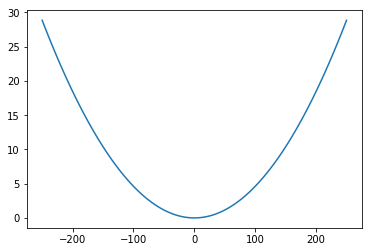

In [33]:
plt.plot(np.linspace(-250, 250, 101), df.loc[(df.X == 0.0) & (df.Y == 0.0)].loc[:, 'V'].values)

In [66]:
0.5*me*(2*np.pi*fz)**2/qe

4489193.560943962